<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Random_forest_Modular(Weekly_New).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/anirbanghoshsbi/pandas-technical-indicators.git

Cloning into 'pandas-technical-indicators'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 202 (delta 105), reused 0 (delta 0), pack-reused 27
Receiving objects: 100% (202/202), 58.64 KiB | 7.33 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [ ]:
!pwd

/content


In [ ]:
%cd pandas-technical-indicators

/content/pandas-technical-indicators


In [ ]:
# Import libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [ ]:
import technical_indicators as ta
import random_forest as rf
import confusionMatrix as cm
import easy_line_ploting as linplt

In [ ]:
tickr ='^NSEI'   #'^NSEI' #^NSEBANK  #^cnxit

In [ ]:
df_old = pd.DataFrame()

In [ ]:
df_old = ta.download_from_yahoo(tickr,'2007-01-01','2017-05-01')

[*********************100%***********************]  1 of 1 downloaded


In [ ]:
df_old.shape

(2343, 5)

# INPUT

In [ ]:
# INPUT .........

#  ********************************* #

t=1
days_out=7


#  ********************************* #

In [ ]:
def weekly_data_formatter(datadf):
    # this is key function to resample data to weekly
    datadf1 = datadf.resample('W', label='left').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
    })

    datadf1.reset_index(level=0, inplace=True)
    # have to add 1 day to each 'Date', tried many ways, only this works.
    datadf1['Date'] = pd.to_datetime(datadf1['Date']).apply(pd.DateOffset(1))
    datadf1 = datadf1.set_index('Date')
    return datadf1

In [ ]:
def get_indicators(data ,days_out,t=1):
    data = ta.relative_strength_index(data,days_out)
    data=ta.exponential_moving_average(data,10*t)
    data=ta.exponential_moving_average(data,50*t)
    data=ta.momentum(data,7*t)
    data=ta.rate_of_change(data,7*t)
    data=ta.exponential_moving_average(data,7*t)
    
    data=ta.exponential_moving_average(data , 13*t)
    data=ta.exponential_moving_average(data ,26*t)
    data=ta.force_index(data ,days_out)
    data = ta.on_balance_volume(data , days_out)
    data = ta.standard_deviation(data , days_out)
    data = ta.stochastic_oscillator_d(data ,days_out)
    data = ta.stochastic_oscillator_k(data)
    data = ta.macd(data , 9 , 12)
    data = ta.ppsr(data)
    data = ta.trix(data,days_out)
    data = ta.vortex_indicator(data , days_out)
    data = ta.find_window_high_low(data,days_out)
    #data = ta.keltner_channel(data , 13)
    #data['change_in_price'] = data['Close'].diff()
    
    return data


# Check This For Weekly or Daily 

In [ ]:
############################ Comment or Uncomment Based on Daily or Weekly ##########

df_old=weekly_data_formatter(df_old)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4213: FutureWarning: DateOffset.__call__ is deprecated and will be removed in a future version.  Use `offset + other` instead.
  mapped = lib.map_infer(values, f, convert=convert_dtype)


In [ ]:
df_old = get_indicators(df_old,days_out,1)

In [ ]:
df_old.tail(2)

,Open,High,Low,Close,Volume,RSI_7,EMA_10,EMA_50,Momentum_7,ROC_7,EMA_7,EMA_13,EMA_26,Force_7,OBV_7,STD_7,SO%d_7,SO%k,MACD_9_12,MACDsign_9_12,MACDdiff_9_12,PP,R1,S1,R2,S2,R3,S3,Trix_7,Vortex_7,Win_High,Win_Low,Signals_from_Window_HiLo
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-04-17,9144.750000,9217.900391,9075.150391,9119.400391,673400,0.557723,9020.177265,8553.865487,221.850586,0.020689,9085.407471,8957.082448,8761.858298,-9.703745e+07,NaN,87.659675,0.383797,0.309982,64.935897,60.971372,3.964524,9137.483724,9199.817058,9057.067058,9280.233724,8994.733724,9342.567058,8914.317058,0.005897,0.267279,9273.900391,8860.099609,0.0
2017-04-24,9135.349609,9367.150391,9130.549805,9304.049805,893700,0.746967,9071.790454,8583.284481,369.500000,0.015720,9140.068055,9006.649214,8802.020632,1.607325e+07,NaN,65.283440,0.471173,0.733303,67.027374,62.182573,4.844802,9267.250000,9403.950196,9167.349610,9503.850586,9030.649414,9640.550782,8930.749024,0.005654,0.388315,9273.900391,8891.950195,1.0


In [ ]:


# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_old['Signal_Flag'] = df_old['Close'].transform(lambda x : np.sign(x.diff(days_out)))
#df_old['Signal_Flag'].head(10)


In [ ]:
df_old = df_old.dropna()
df_old.shape

(443, 34)

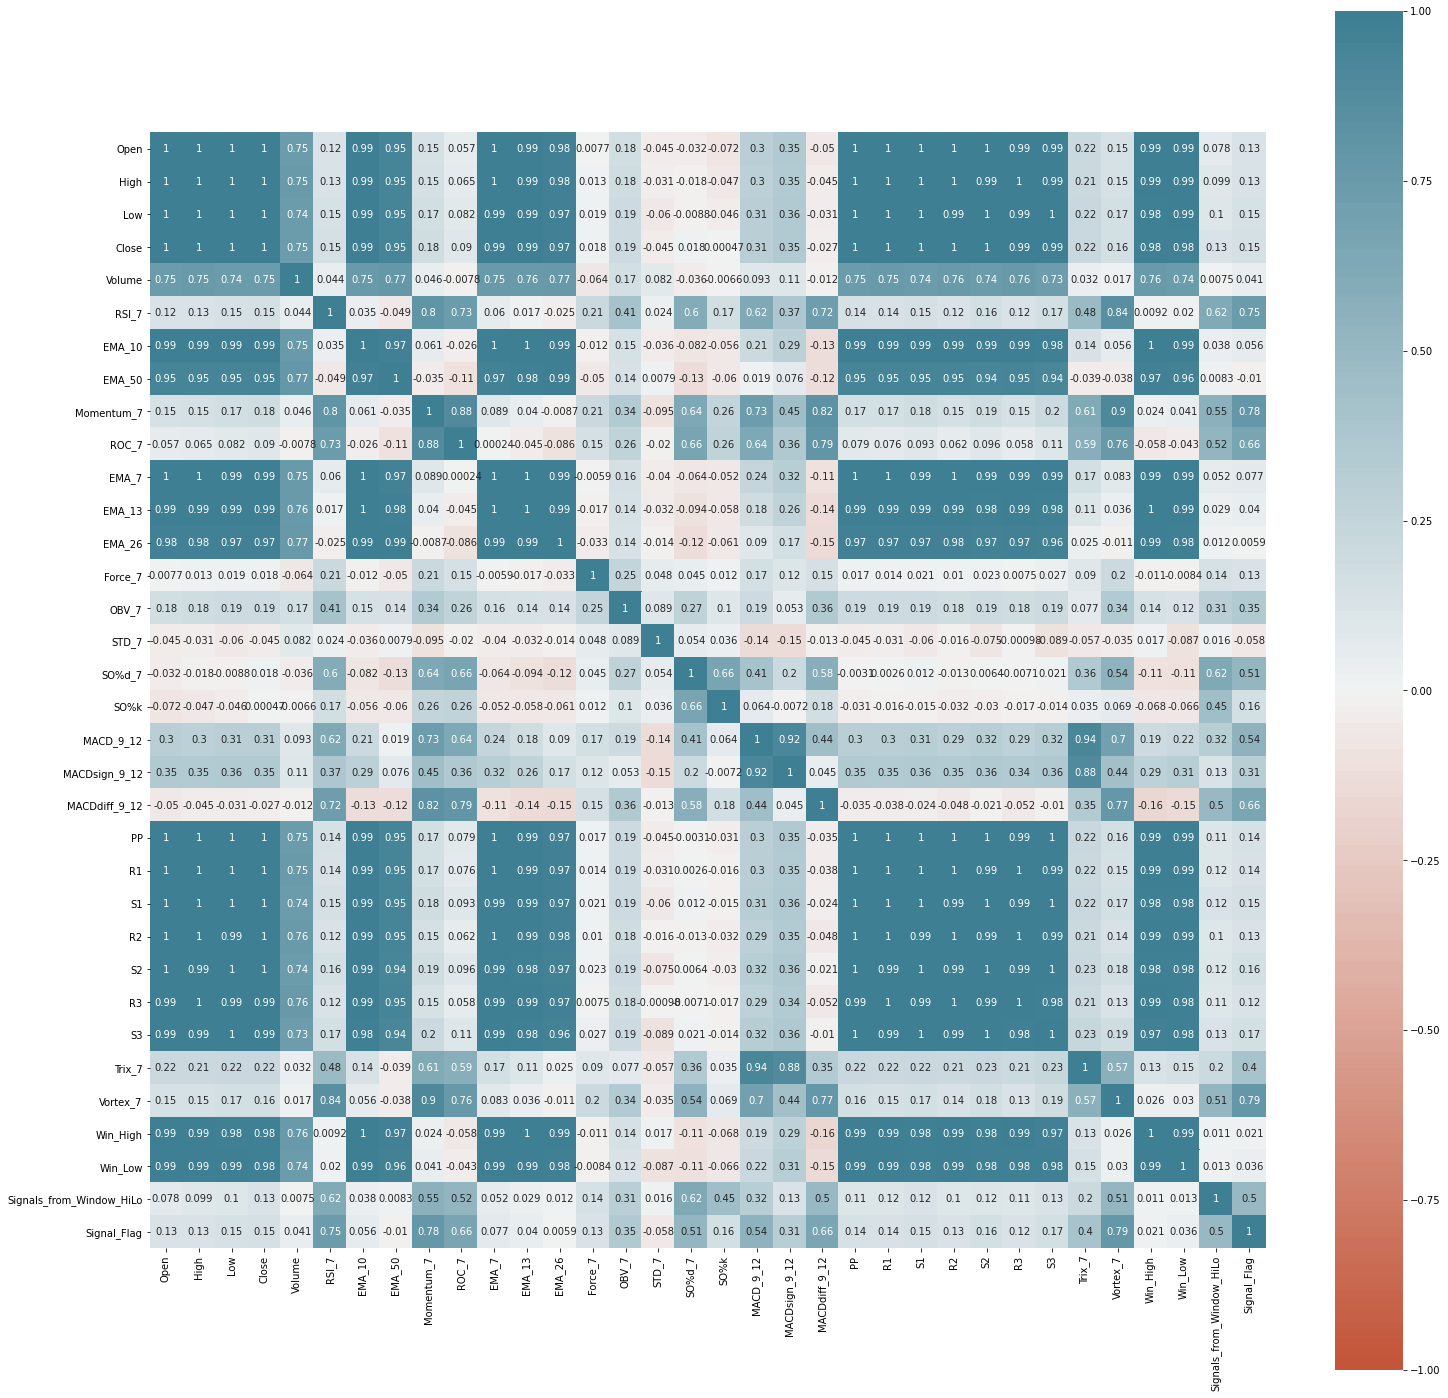

In [ ]:
ta.correlation_map(df_old,25)

In [ ]:
X_Cols = df_old.drop(['Signal_Flag'],axis=1)
Y_Cols = df_old['Signal_Flag']
samp_train = int(len(df_old)*.75 -50)
samp_test = samp_train+50
X_train = X_Cols[:samp_train]
X_test = X_Cols[samp_test:]
y_train = Y_Cols[:samp_train]
y_test = Y_Cols[samp_test:]

In [ ]:


#rf.best_param_rf(X_train , y_train , 100)

In [ ]:
'''
>>> 100 iterations
{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 37.9min finished
{'Best Score': 0.9169554134840112,
 'Best parameters': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 60,
  'max_features': None,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 7,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 200,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  
>>> for n_iter=300
{'Best Score': 0.9654412531082027,
 'Best parameters': {'bootstrap': False,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 10,
  'max_features': None,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 16,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 1800,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  '''

"\n100 iterations\n{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}\nFitting 3 folds for each of 100 candidates, totalling 300 fits\n[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.\n[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min\n[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.3min\n[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 37.9min finished\n{'Best Score': 0.9169554134840112,\n 'Best parameters': {'bootstrap': True,\n  'ccp_alpha': 0.0,\n  'class_weight': None,\n  'criterion': 'gini',\n  'max_depth': 60,\n  'max_features': None,\n  'max_leaf_nodes': None,\n  'max_samples': None,\n  'min_impurity_decrease': 0.0,\n  'min_impurity_split': None,\n  'min_samples_leaf': 7,\n  'min_sa

In [ ]:
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 400,max_depth=50,min_samples_leaf=14,max_features='auto', min_samples_split=2, criterion = "gini", bootstrap=True,random_state = 42)
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)


In [ ]:
# Print the Accuracy of our Model.
print('Correct Prediction RForest (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction RForest (%):  100.0


Accuracy: 100.0
Percision: 100.0
Recall: 100.0
Specificity: 100.0


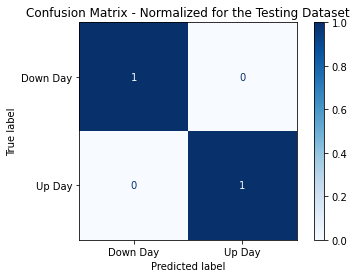

In [ ]:
cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True )

#cm.confus_matrix(actual_results , predictions,model ,<test data ( or new_data for prediction except target VAR)>, <actaul Target VAR> , <plot=True>)

In [ ]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp*100

Momentum_7                  27.357896
Vortex_7                    15.128962
ROC_7                       15.096753
RSI_7                       13.216348
MACDdiff_9_12               10.572721
MACD_9_12                    4.705990
SO%d_7                       4.183669
Trix_7                       2.232055
Signals_from_Window_HiLo     1.279472
MACDsign_9_12                1.095935
Low                          0.462416
S1                           0.442736
S3                           0.356646
PP                           0.329357
SO%k                         0.325396
EMA_50                       0.315406
STD_7                        0.313151
Win_High                     0.307048
R2                           0.283263
S2                           0.273603
Close                        0.266241
EMA_26                       0.247222
High                         0.227496
R3                           0.182276
R1                           0.155301
Open                         0.155193
Win_Low     

# Logistic Regression

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
LogReg = LogisticRegression()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
LogReg.fit(X_train, y_train)
y_predL = LogReg.predict(X_test)

In [ ]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', accuracy_score(y_test, LogReg.predict(X_test), normalize = True) * 100.0)

Correct Prediction Logistic Regression (%):  96.3963963963964


Accuracy: 96.3963963963964
Percision: 96.72131147540983
Recall: 96.72131147540983
Specificity: 96.0


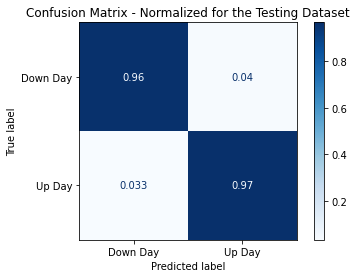

In [ ]:
cm.confus_matrix(y_test,y_predL,LogReg,X_test,y_test,plot=True )

# Support Vector Classifier

In [ ]:
from sklearn.svm import SVC
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
svc_classifier = SVC(kernel = 'linear', random_state = 0)
svc_classifier.fit(X_train, y_train)
y_predS = svc_classifier.predict(X_test)

In [ ]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', accuracy_score(y_test, svc_classifier.predict(X_test), normalize = True) * 100.0)

Correct Prediction Logistic Regression (%):  95.4954954954955


Accuracy: 95.4954954954955
Percision: 92.42424242424242
Recall: 100.0
Specificity: 90.0


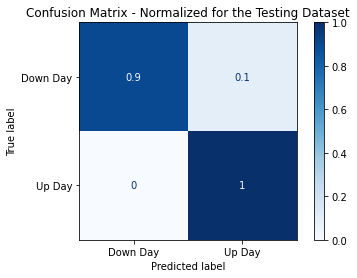

In [ ]:
cm.confus_matrix(y_test,y_predS,svc_classifier,X_test,y_test,plot=True )

# XGBoost Classifier

In [ ]:
from sklearn.svm import SVC
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
svc_classifier = SVC(kernel = 'linear', random_state = 0)
svc_classifier.fit(X_train, y_train)
y_predS = svc_classifier.predict(X_test)

In [ ]:
import xgboost as xgb

In [ ]:
'''
param_test1 = {
 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1,0.05],
 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],
 'n_estimators': [10,50,100,200,300]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=10,cv=5)
 
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_
'''

"\nparam_test1 = {\n 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1,0.05],\n 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],\n 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],\n 'n_estimators': [10,50,100,200,300]\n}\ngsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,\n min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \n param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=10,cv=5)\n \ngsearch1.fit(X_train,y_train)\ngsearch1.best_params_, gsearch1.best_score_\n"

In [ ]:
xgb_classifier = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_classifier.fit(X_train, y_train)
y_predX = xgb_classifier.predict(X_test)
print("Accuracy for XGBoost Model: %.2f" % (accuracy_score(y_test, y_predX) * 100))

Accuracy for XGBoost Model: 100.00


In [ ]:
feature_imp_ = pd.Series(xgb_classifier.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp_*100

Momentum_7                  56.336658
Vortex_7                    23.619486
ROC_7                        6.885078
Open                         5.022392
RSI_7                        3.107567
STD_7                        2.774892
MACDdiff_9_12                1.893004
SO%d_7                       0.360918
R2                           0.000000
EMA_13                       0.000000
High                         0.000000
Low                          0.000000
Close                        0.000000
Volume                       0.000000
Win_High                     0.000000
EMA_10                       0.000000
EMA_50                       0.000000
Trix_7                       0.000000
S3                           0.000000
EMA_7                        0.000000
EMA_26                       0.000000
S1                           0.000000
Force_7                      0.000000
OBV_7                        0.000000
R3                           0.000000
Win_Low                      0.000000
SO%k        

Accuracy: 100.0
Percision: 100.0
Recall: 100.0
Specificity: 100.0


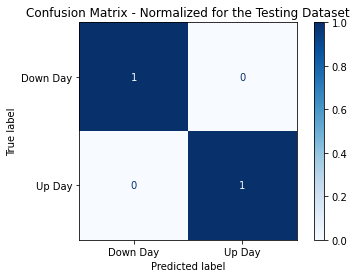

In [ ]:
cm.confus_matrix(y_test,y_predX,xgb_classifier,X_test,y_test,plot=True )

# Make Actual Prediction

In [ ]:
df = pd.DataFrame()

In [ ]:
df = ta.download_from_yahoo(tickr,'2018-01-01')

[*********************100%***********************]  1 of 1 downloaded


In [ ]:
df.tail(2)

,Open,High,Low,Close,Volume
Date,,,,,
2021-06-03,15655.549805,15705.099609,15611.000000,15690.349609,410200
2021-06-04,15712.500000,15733.599609,15622.349609,15670.250000,414200


# Check This For Weekly or Daily

In [ ]:
####################### Comment or Uncomment Based on Weekly or Daily ##################
df=weekly_data_formatter(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4213: FutureWarning: DateOffset.__call__ is deprecated and will be removed in a future version.  Use `offset + other` instead.
  mapped = lib.map_infer(values, f, convert=convert_dtype)


In [ ]:
df = get_indicators(df,days_out,1)
#df= impulse(df)

In [ ]:
df.tail(2)

,Open,High,Low,Close,Volume,RSI_7,EMA_10,EMA_50,Momentum_7,ROC_7,EMA_7,EMA_13,EMA_26,Force_7,OBV_7,STD_7,SO%d_7,SO%k,MACD_9_12,MACDsign_9_12,MACDdiff_9_12,PP,R1,S1,R2,S2,R3,S3,Trix_7,Vortex_7,Win_High,Win_Low,Signals_from_Window_HiLo
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-24,15211.349609,15469.650391,15145.450195,15435.650391,1873400,0.832821,14871.659575,13439.102085,600.800782,0.055945,14959.887717,14783.315677,14282.762446,-7.840450e+07,3.780143e+05,372.143427,0.705352,0.895127,85.678916,88.625039,-2.946124,15350.250326,15555.050456,15230.850260,15674.450522,15026.050130,15879.250652,14906.650064,0.002487,0.343152,15190.000000,14151.400391,1.0
2021-05-31,15437.750000,15733.599609,15374.000000,15670.250000,2098600,0.882617,15016.857834,13526.666059,1052.400391,0.092662,15137.478288,14910.020580,14385.539409,-3.177197e+08,1.020743e+06,477.170459,0.734972,0.823833,108.062309,92.512493,15.549816,15592.616536,15811.233073,15451.633464,15952.216145,15233.016927,16170.832682,15092.033855,0.003475,0.678077,15469.650391,14151.400391,1.0


In [ ]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df['Signal_Flag'] = df['Close'].transform(lambda x : np.sign(x.diff(days_out)))

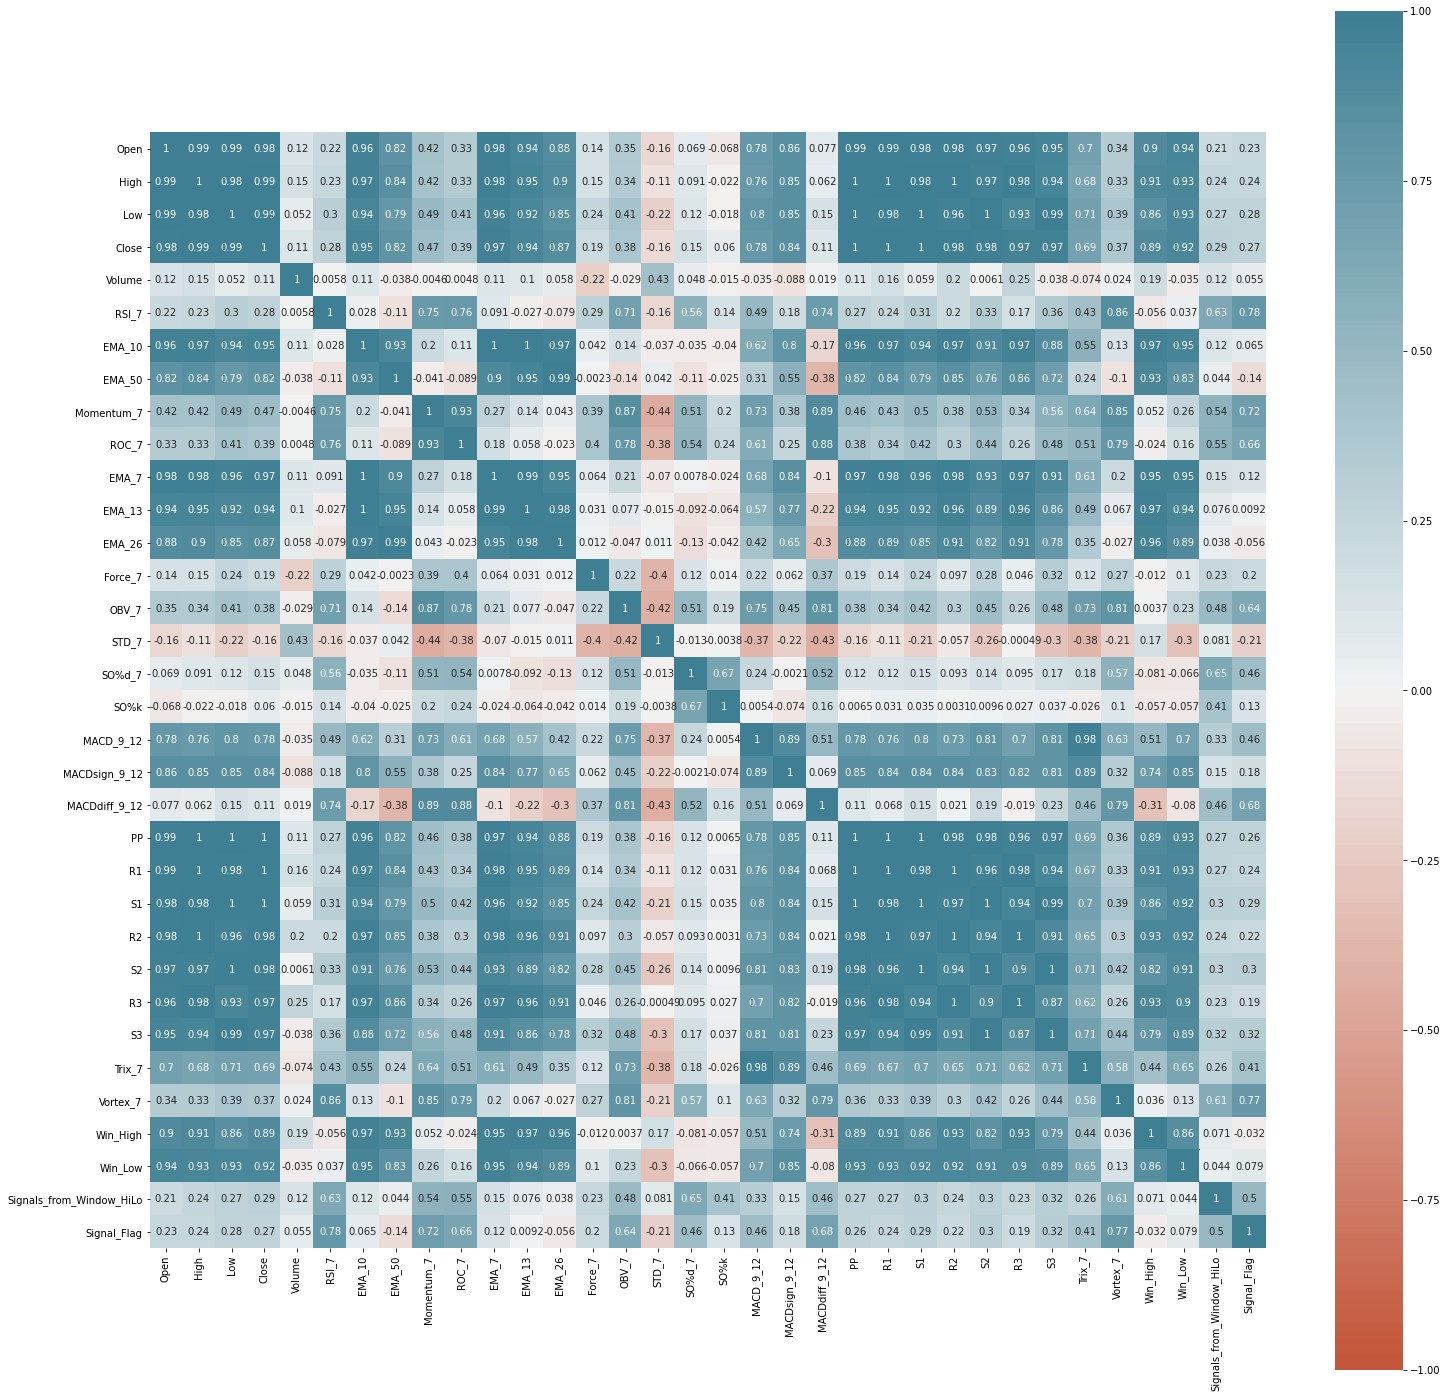

In [ ]:
ta.correlation_map(df,25)

In [ ]:
df.shape

(179, 34)

In [ ]:
df=df.dropna()

In [ ]:
df.shape

(130, 34)

In [ ]:
new_data = df.drop(['Signal_Flag'],axis=1)
actuals= df['Signal_Flag']


# Make Predictions Using Random Forest

In [ ]:
model='random_forest'

In [ ]:
preds=rf.make_preds(new_data ,rand_frst_clf,model,df)

In [ ]:
print("days_out : ",days_out)

days_out :  7


In [ ]:
preds.head(2)

,predsrandom_forest
Date,
2018-12-10,1.0
2018-12-17,1.0


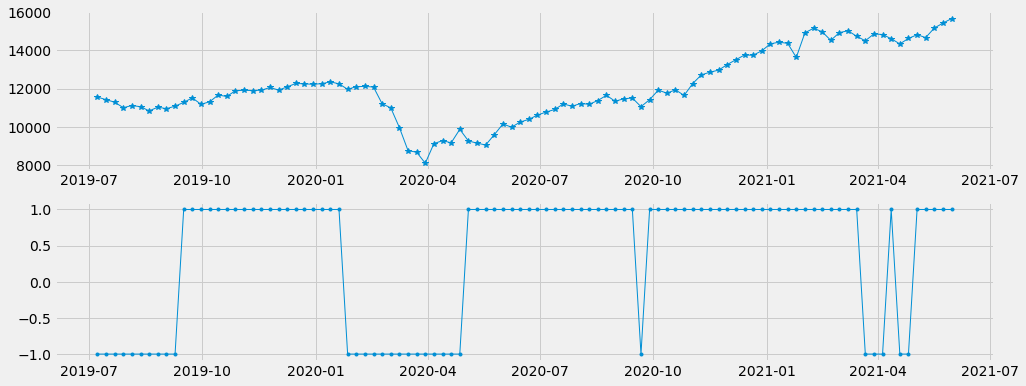

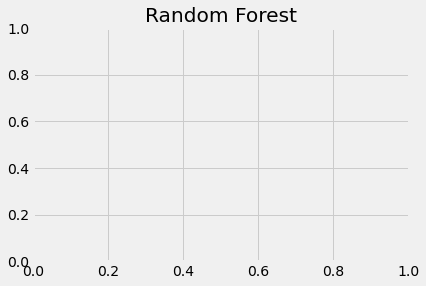

In [ ]:
linplt.lineplot(2,15,6,df,preds['predsrandom_forest'], no_of_datapoints=100) # no_of_datapoints=100
plt.title('Random Forest')
plt.show()

In [ ]:
pred = pd.DataFrame(rf.make_preds(new_data , rand_frst_clf, model,df))

In [ ]:
pred.head(2)

,predsrandom_forest
Date,
2018-12-10,1.0
2018-12-17,1.0


In [ ]:
pred = pd.concat([pred ,df.Close],axis=1)
#pred.columns=['Date','preds','Close']
#pred= pred.set_index('Date')

In [ ]:
l=len(pred)

In [ ]:
#fig, ax = plt.subplots(1,1,figsize=(20,7))
#Identifying the buy/sell zone
pred['Buy_ind'] = np.where((pred['predsrandom_forest']==1), 1, 0)
pred['Sell_ind'] = np.where((pred['predsrandom_forest']==-1), 0, 1)

In [ ]:
pred=pred.reset_index()

# Make Prediction Using XGBoost

In [ ]:
model='_XGB'

In [ ]:
predX=rf.make_preds(new_data.values ,xgb_classifier,model,df)

In [ ]:
predX= pd.concat([predX ,df.Close],axis=1)

In [ ]:
predX.head(2)

,preds_XGB,Close
Date,,
2018-12-10,1.0,10805.450195
2018-12-17,1.0,10754.000000


In [ ]:
#Identifying the buy/sell zone
predX['Buy_ind_XGB'] = np.where((predX['preds_XGB']==1), 1, 0)
predX['Sell_ind_XGB'] = np.where((predX['preds_XGB']==-1), 0, 1)

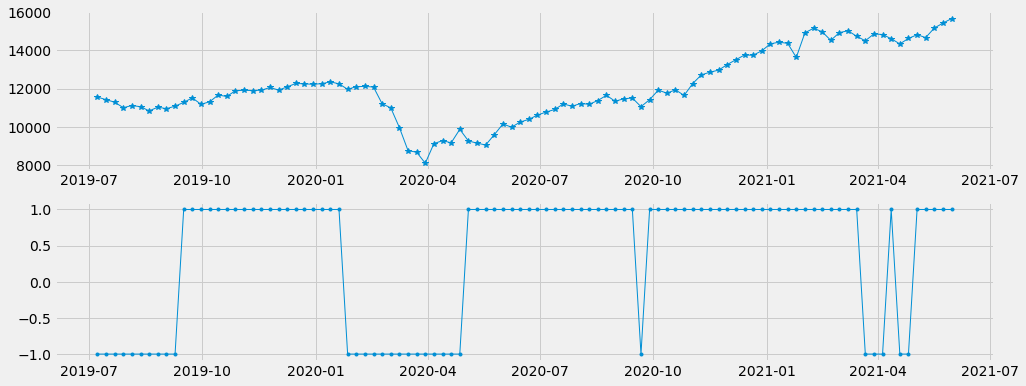

In [ ]:
linplt.lineplot(2,15,6,df,predX['preds_XGB'], no_of_datapoints=100) # no_of_datapoints=100

In [ ]:
predX=predX.reset_index()

# Make Prediction Using Logistics Regression

In [ ]:
model='_Logistic_Regression'

In [ ]:
preds_logreg=pd.DataFrame(rf.make_preds(new_data , LogReg,model, df))

In [ ]:
preds_logreg.head(2)

,preds_Logistic_Regression
Date,
2018-12-10,1.0
2018-12-17,-1.0


In [ ]:
predL = pd.concat([preds_logreg ,df.Close],axis=1)

In [ ]:
predL=predL.reset_index()

In [ ]:
#Identifying the buy/sell zone
predL['Buy_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==1), 1, 0)
predL['Sell_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==-1), 0, 1)

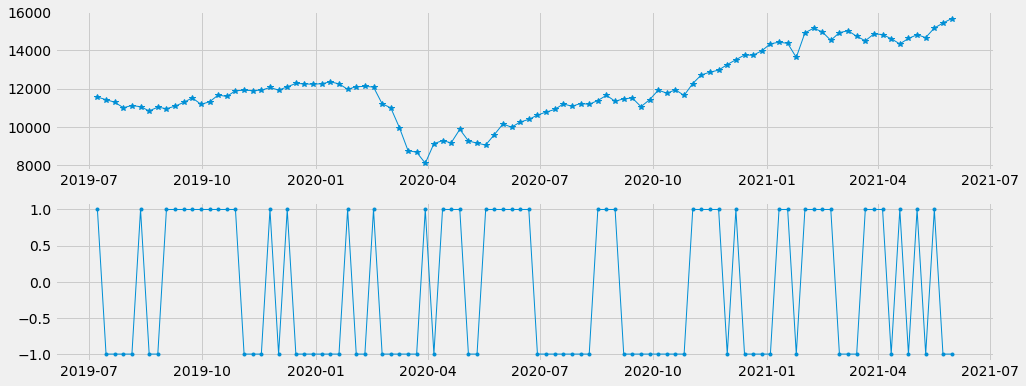

In [ ]:
linplt.lineplot(2,15,6,df,preds_logreg['preds_Logistic_Regression'], no_of_datapoints=100) # no_of_datapoints=100

# Make Predictions using Support Vector Classifier

In [ ]:
model='_SVC'

In [ ]:
preds_svc=pd.DataFrame(rf.make_preds(new_data ,svc_classifier,model, df))

In [ ]:
predS = pd.concat([preds_svc,df.Close],axis=1)

In [ ]:
predS=predS.reset_index()

In [ ]:
#Identifying the buy/sell zone
predS['Buy_ind_SVC'] = np.where((predS['preds_SVC']==1), 1, 0)
predS['Sell_ind_SVC'] = np.where((predS['preds_SVC']==-1), 0, 1)

# PREDICTIONS

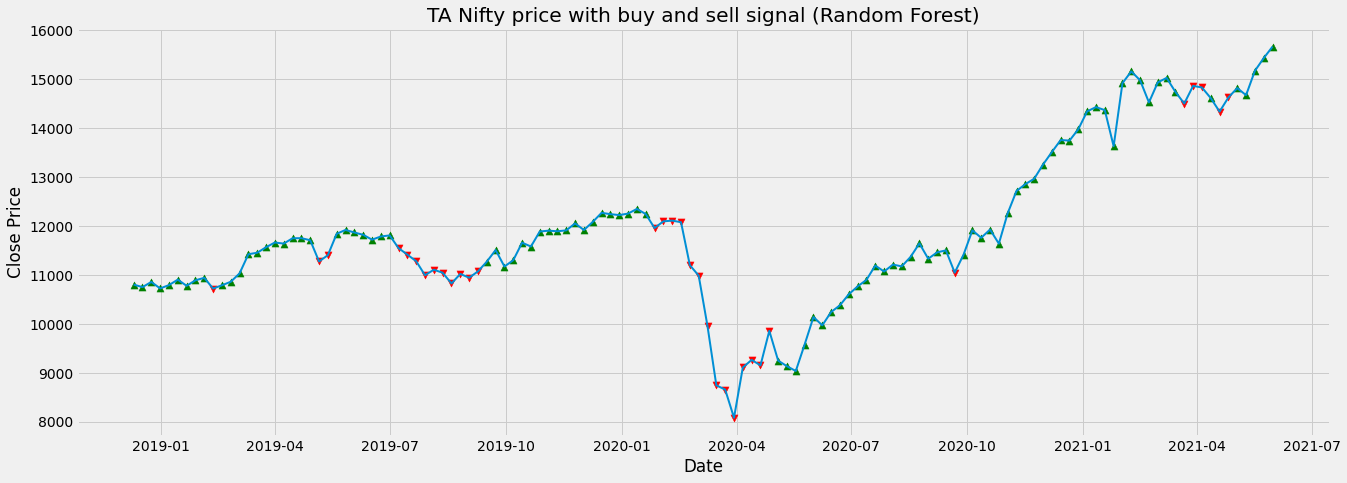

In [ ]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=2)
plt.scatter(pred.loc[pred['Buy_ind'] ==1 , 'Date'].values,pred.loc[pred['Buy_ind'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(pred.loc[pred['Sell_ind'] ==0 , 'Date'].values,pred.loc[pred['Sell_ind'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Random Forest)') 

plt.savefig('a.png')
plt.show();

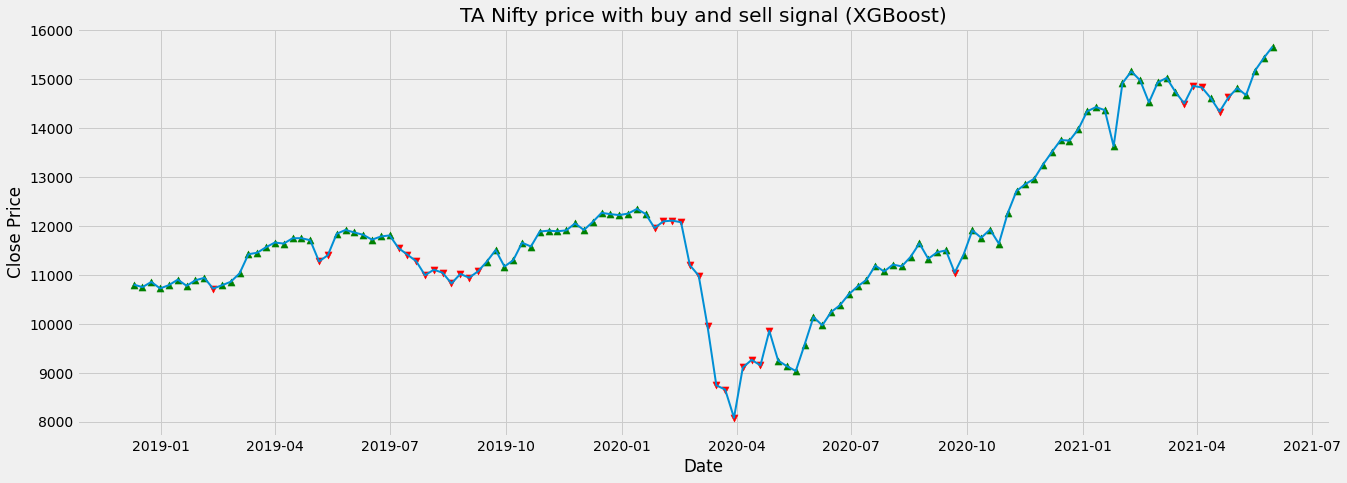

In [ ]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=2)
plt.scatter(predX.loc[predX['Buy_ind_XGB'] ==1 , 'Date'].values,predX.loc[predX['Buy_ind_XGB'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predX.loc[predX['Sell_ind_XGB'] ==0 , 'Date'].values,predX.loc[predX['Sell_ind_XGB'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (XGBoost)') 

plt.savefig('a.png')
plt.show();

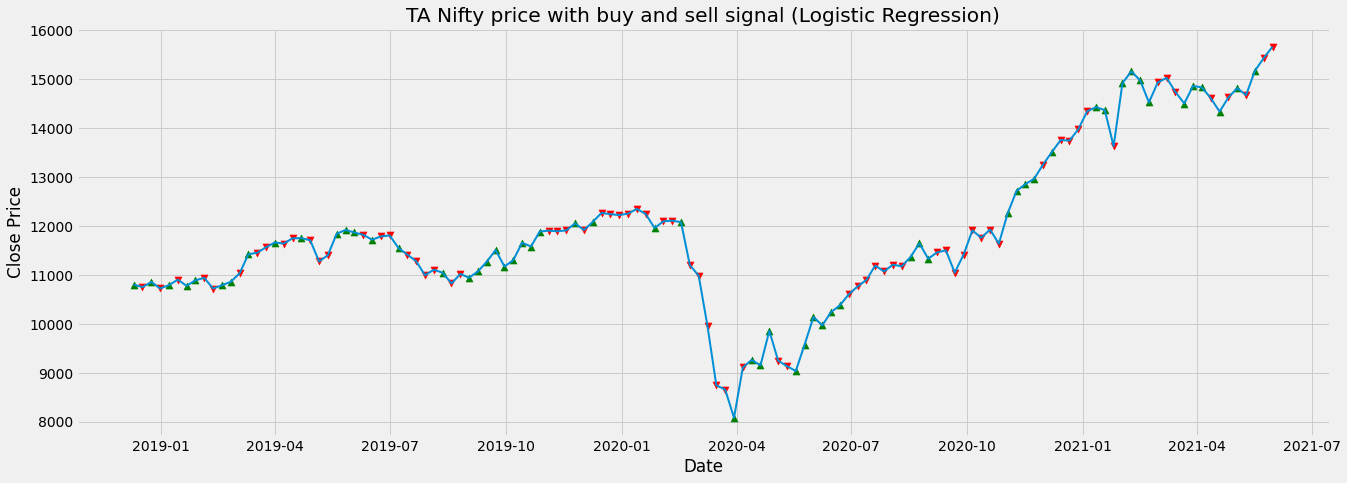

In [ ]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=2)
plt.scatter(predL.loc[predL['Buy_ind_Logreg'] ==1 , 'Date'].values,predL.loc[predL['Buy_ind_Logreg'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predL.loc[predL['Sell_ind_Logreg'] ==0 , 'Date'].values,predL.loc[predL['Sell_ind_Logreg'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Logistic Regression)') 

plt.savefig('a.png')
plt.show();

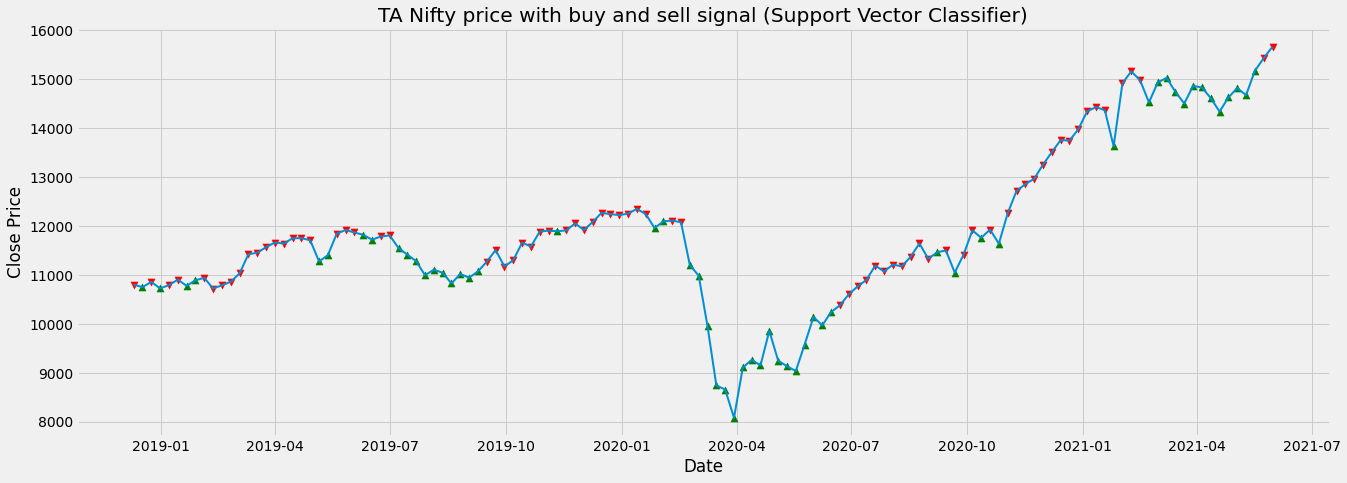

In [ ]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=2)
plt.scatter(predS.loc[predS['Buy_ind_SVC'] ==1 , 'Date'].values,predS.loc[predS['Buy_ind_SVC'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predS.loc[predS['Sell_ind_SVC'] ==0 , 'Date'].values,predS.loc[predS['Sell_ind_SVC'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Support Vector Classifier)') 

plt.savefig('a.png')
plt.show();

In [ ]:
pred['ensemble'] = predX['preds_XGB']*2+pred['predsrandom_forest']*2+predL['preds_Logistic_Regression']*.5+predS['preds_SVC']*0.5

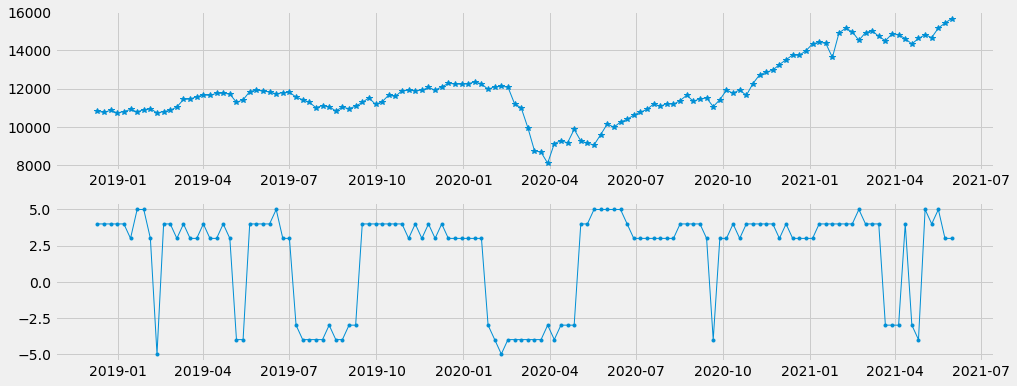

In [ ]:
linplt.lineplot(2,15,6,df,pred['ensemble'], no_of_datapoints=200) # no_of_datapoints=100

In [ ]:
#Identifying the buy/sell zone
pred['Buy_ensemble'] = np.where((pred['ensemble']>=2.5), 1, 0)
pred['Sell_ensemble'] = np.where((pred['ensemble']<2.5), 0, 1)
pred['Neutral'] = np.where((pred['ensemble']==0),0,1)

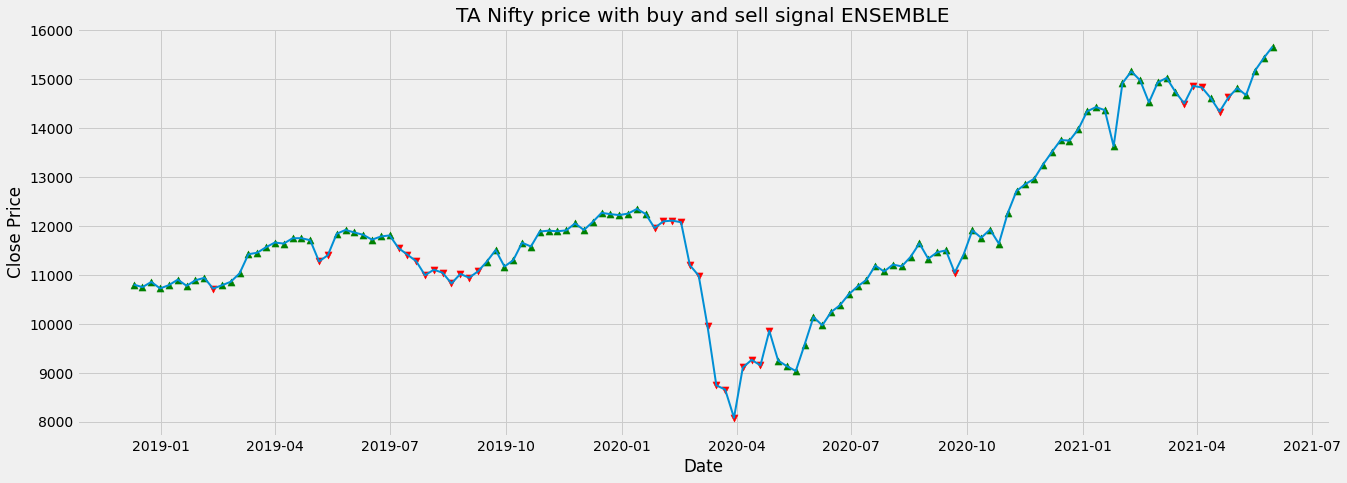

In [ ]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=2)
plt.scatter(pred.loc[pred['Buy_ensemble'] ==1 , 'Date'].values,pred.loc[pred['Buy_ensemble'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(pred.loc[pred['Sell_ensemble'] ==0 , 'Date'].values,pred.loc[pred['Sell_ensemble'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")
#plt.scatter(pred.loc[pred['Neutral'] ==0 , 'Date'].values,pred.loc[pred['Neutral'] ==0, 'Close'].values, label='skitscat', color='blue', s=50, marker="*")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal ENSEMBLE') 
plt.show();

Accuracy: 100.0
Percision: 100.0
Recall: 100.0
Specificity: 100.0


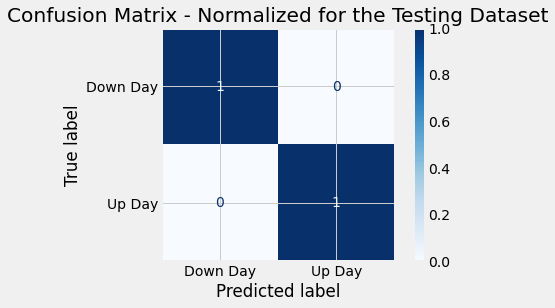

In [ ]:
cm.confus_matrix(df.Signal_Flag,preds,rand_frst_clf,new_data,actuals,plot=True )


Accuracy: 100.0
Percision: 100.0
Recall: 100.0
Specificity: 100.0


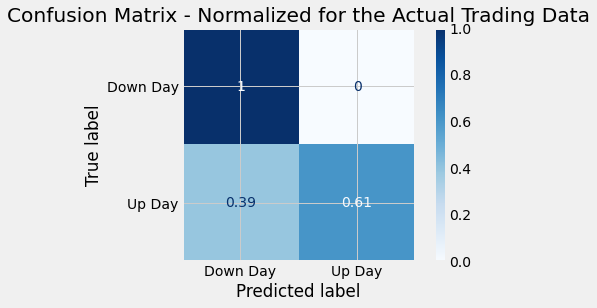

In [ ]:
cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True, test=False)


In [ ]:
# saving the dataframe
pred.to_csv('/content/rf_TA.csv')

In [ ]:
df.tail(2)

,Open,High,Low,Close,Volume,RSI_7,EMA_10,EMA_50,Momentum_7,ROC_7,EMA_7,EMA_13,EMA_26,Force_7,OBV_7,STD_7,SO%d_7,SO%k,MACD_9_12,MACDsign_9_12,MACDdiff_9_12,PP,R1,S1,R2,S2,R3,S3,Trix_7,Vortex_7,Win_High,Win_Low,Signals_from_Window_HiLo,Signal_Flag
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-24,15211.349609,15469.650391,15145.450195,15435.650391,1873400,0.832821,14871.659575,13439.102085,600.800782,0.055945,14959.887717,14783.315677,14282.762446,-7.840450e+07,3.780143e+05,372.143427,0.705352,0.895127,85.678916,88.625039,-2.946124,15350.250326,15555.050456,15230.850260,15674.450522,15026.050130,15879.250652,14906.650064,0.002487,0.343152,15190.000000,14151.400391,1.0,1.0
2021-05-31,15437.750000,15733.599609,15374.000000,15670.250000,2098600,0.882617,15016.857834,13526.666059,1052.400391,0.092662,15137.478288,14910.020580,14385.539409,-3.177197e+08,1.020743e+06,477.170459,0.734972,0.823833,108.062309,92.512493,15.549816,15592.616536,15811.233073,15451.633464,15952.216145,15233.016927,16170.832682,15092.033855,0.003475,0.678077,15469.650391,14151.400391,1.0,1.0
